# **Homogenisation**

This notebook is developed for the "Optimisation & Machine Learning" workshop, organised by UK Metamaterials Network (UKMMN); for educational purposes only.
- Authors: Erin Yu, Amber Wang and Ajit Panesar (IDEA Lab, Imperial College London)
- Version: v1 (10/01/2025)
- Comments and corrections to a.panesar@imperial.ac.uk, erin.yu22@imperial.ac.uk, a.wang20@imperial.ac.uk

### **Table of Contents**
1) Introduction

2) Homogenisation in 2D
    - Assumptions
    - Case 1: solid square plate
    - Case 2: cross shape
    - Case 3: BCC

3) Lattice-specific penalty factor calculation

4) Create the dataset

5) Homogenisation in 3D (optional)

----------------------------------------------------------------------

### **1) Introduction**

Homogenisation is the process of replacing a complex microstructure with an equivalent material that captures its average response.

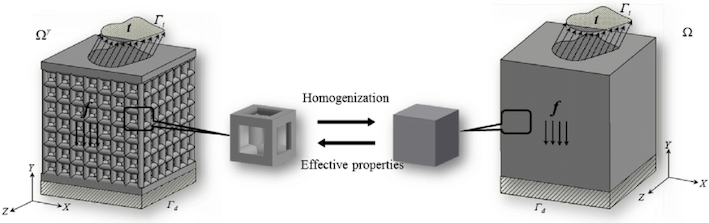

Computationally, homogenisation is performed by applying unit loading cases with periodic boundary conditions on the representative volume element (RVE) and averaging the resulting stress-strain fields to obtain the effective constitutive matrix.

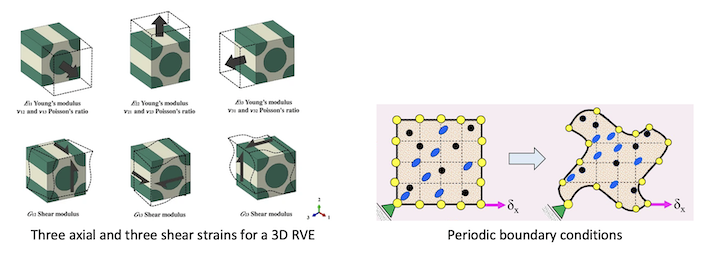

The effective property is dependent on the RVE's geometry and material. <br> Let's visualise the directional stiffness for various designs, with relative density all equal to 0.1

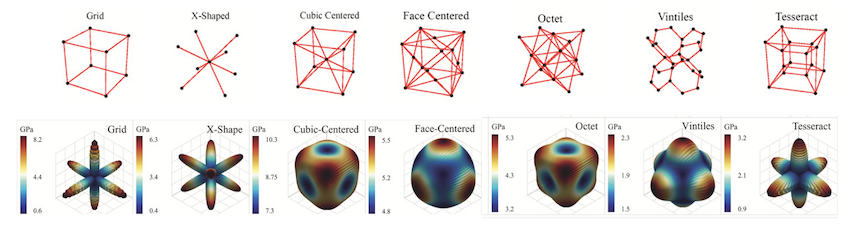

Run the cell below to import necessarry python libraries for this tutorial.

In [1]:
# Import statements

# --- Clone repository from Git
!git clone https://github.com/amberwang56977/MLLab.git
%cd MLLab

import itertools
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

from homogenise2D import compute_lambda_constants, homogenise, plot_directional_stiffness
from homogenise2D import generate_cross_unit_cell, generate_BCC_unitcell

Cloning into 'MLLab'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 42 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 3.41 MiB | 9.04 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/MLLab


### **2) Homogenisation in 2D**
#### **Assumptions for the 2D unit cell**

- Equal side length in x and y direction: lx=ly=1
- Angle between x anb y axis: phi=90 degrees
- Number of pixel per side: a=50
- Material property: E=100, nu=0.3

In [2]:
# Unit Cell Geometry
lx = 1
ly = 1
phi = 90
a = 50

# Material Property
E = 100
nu = 0.3
lambda_vals, mu_vals = compute_lambda_constants(E, nu)

#### **Case 1: Solid square plate**

Generate a solid square plate without void

Solid square plate:


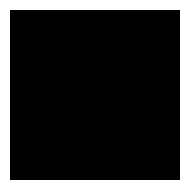

Homogenised Elasticity Tensor:
[[134.6154  57.6923  -0.    ]
 [ 57.6923 134.6154   0.    ]
 [ -0.       0.      38.4615]]


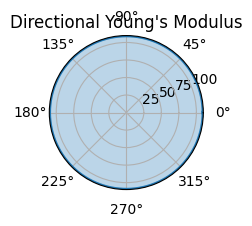

In [3]:
# A solid square plate
# pattern = np.ones((a, a))
print('Solid square plate:')
pattern = generate_cross_unit_cell(a, 1, 1)

# Homogenised elasticity tensor
D = homogenise(lx, ly, lambda_vals, mu_vals, phi, pattern)
print("Homogenised Elasticity Tensor:")
print(D)

# Visualise directional stiffness
plot_directional_stiffness(D)

The circle above indicates that the stiffness is the same for all directions. <br>
Therefore, homogenising a solid block is equivalent to using the base material's isotropic property.

In [4]:
mat_id = 1
print(f"Normal diagonal component: {lambda_vals[mat_id] + 2*mu_vals[mat_id]:.4f}")
print(f"Normal off-diagonal component: {lambda_vals[mat_id]:.4f}")
print(f"Shear component: {mu_vals[mat_id]:.4f}")

Normal diagonal component: 134.6154
Normal off-diagonal component: 57.6923
Shear component: 38.4615


#### **Case 2: Cross Shape**

Create a cross-shape unit cell with different width and height <br>
Observe how the directional stiffness closely resemble the cross shape

Cross shape:


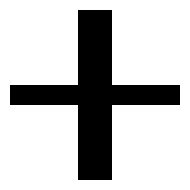

Homogenised Elasticity Tensor:
[[13.9982  1.3945 -0.    ]
 [ 1.3945 22.3963  0.    ]
 [-0.      0.      0.214 ]]


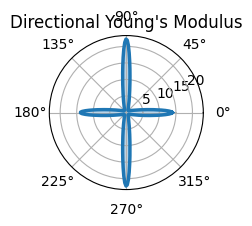

Observe that the stiffness is higher in x and y direction, approximately corresponding to the cross shape's geometric parameters.


In [5]:
# Cross-shape unit cell
# Define the ratio between the cross width/height with respect to the unit cell side length
rx = 0.2
ry = 0.1

# Cross-shape pattern
print('Cross shape:')
pattern = generate_cross_unit_cell(a, rx, ry)

# Homogenised elasticity tensor
D = homogenise(lx, ly, lambda_vals, mu_vals, phi, pattern)
print("Homogenised Elasticity Tensor:")
print(D)

# Visualise directional stiffness
plot_directional_stiffness(D)
print("Observe that the stiffness is higher in x and y direction, approximately corresponding to the cross shape's geometric parameters.")

#### **Case 3: BCC**

Create a Body-Centered-Cubic (BCC) unit cell with different nodal radius <br>
Observe how the unit cell is homogenised into an anisotropic material

BCC:


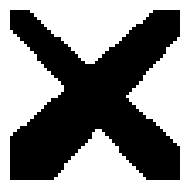

Homogenised Elasticity Tensor:
[[26.989  19.7992 -2.1471]
 [19.7992 24.4357 -1.9012]
 [-2.1471 -1.9012 16.2439]]


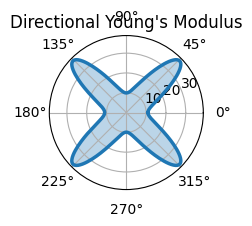

Observe that the load-carry capability align with the BCC shape, stronger in digonal directions.


In [6]:
# BCC unit cell with varying radius
print('BCC:')
pattern = generate_BCC_unitcell(a, r1=0.1, r2=0.15, r3=0.20, r4=0.25)

# Homogenised elasticity tensor
D = homogenise(lx, ly, lambda_vals, mu_vals, phi, pattern)
print("Homogenised Elasticity Tensor:")
print(D)

# Visualise directional stiffness
plot_directional_stiffness(D)
print("Observe that the load-carry capability align with the BCC shape, stronger in digonal directions.")

### **3) Lattice-Specific Penalty Factor Calculation**

Explore the relationship between elasticity matrix (e.g. D11 term) and the lattice's volume fraction (vf). <br>
The example below uses a BCC lattice with constant nodal radius. <br>
Similar to the SIMP interpolation scheme, we will fit a power law relationship to find the penalty factor p: D11=E*(vf^p) <br>
For reference, values of r in the range of [0.05, 0.3] will result in VF range [0.20, 0.85]

Penalty factor P= 2.2081


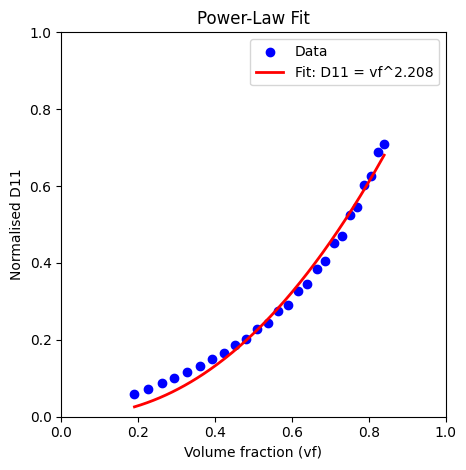

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Compute elasticity and vf for a set of designs
r_values = np.arange(0.05, 0.31, 0.01)
D11s = []
vfs = []

for r in r_values:
    pattern = generate_BCC_unitcell(a=a, r1=r, r2=r, r3=r, r4=r, show=False)
    vf = np.count_nonzero(pattern) / pattern.size
    D = homogenise(lx, ly, lambda_vals, mu_vals, phi, pattern)
    vfs.append(vf)
    D11s.append(D[0,0]/E)

# Power-law function with fixed E
def power_law(vf, p):
    #return E * (vf ** p)
    return vf ** p

# Fit only p
params, covariance = curve_fit(power_law, vfs, D11s, p0=[3.0])  # initial guess p=3
p_fitted = params[0]

# Generate fitted curve
x_fit = np.linspace(min(vfs), max(vfs), 200)
y_fit = power_law(x_fit, p_fitted)
print(f"Penalty factor P= {p_fitted:.4f}")

# Plot
plt.scatter(vfs, D11s, label="Data", color="blue")
plt.plot(x_fit, y_fit, 'r-',
         #label=f"Fit: D11 = {E} * vf^{p_fitted:.3f}",
         label=f"Fit: D11 = vf^{p_fitted:.3f}",
         linewidth=2)

plt.xlabel("Volume fraction (vf)")
plt.ylabel("Normalised D11")
plt.title("Power-Law Fit")
plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

### **4) Create the Dataset**

Create a dataset for the BCC unit cell with varying nodal radius:
- Sample r in the range of 0.1 to 0.3 with a step size of 0.05
- param: [r1, r2, r3, r4] <br>
- prop: [D11, D12, D13, D22, D23, D33, vf] <br>

In [8]:
# Unit cell design
import itertools

# Define range of r values
# r_values = np.arange(0.05, 0.31, 0.05)  # [0.05, 0.10, ..., 0.30]
r_values = np.arange(0.1, 0.21, 0.1)  # [0.05, 0.10, ..., 0.30]

patterns = []
param = []  # store (r1,r2,r3,r4)

for r1, r2, r3, r4 in itertools.product(r_values, repeat=4):
    pattern = generate_BCC_unitcell(a, r1, r2, r3, r4, show=False)
    patterns.append(pattern)
    param.append((r1, r2, r3, r4))

param = np.array(param)
patterns = np.array(patterns)

print("Total patterns generated:", len(patterns))

Total patterns generated: 16


Construct the property features: 6 independent entries of the constitutive matrix + volume fraction

In [9]:
# Construct property features
prop = []

for pattern in patterns:

    # Homogenisation 2D
    # x = np.where(pattern == 1, 1, 2)
    D = homogenise(lx, ly, lambda_vals, mu_vals, phi, pattern)

    # Calculate the volume fraction
    vf = np.count_nonzero(pattern) / pattern.size

    # Construct the property features
    prop.append([D[0,0], D[0,1], D[0,2], D[1,1], D[1,2], D[2,2], vf])

prop = np.array(prop)

Optionally save the dataset

In [10]:
# Save the dataset
# np.savez("user_defined_dataset_2D_BCC.npz", prop=prop, param=param)

### **<span style="color:lightblue;"> 5) Homogenisation in 3D (Optional)</span>**

If you want to further explore homogenisation in 3D <br>
- Suggested reading: Ozdilek et al, "A finite element based homogenization code in python: HomPy", Advances in Engineering Software, Aug 2024, https://doi.org/10.1016/j.advengsoft.2024.103674 <br>
- Open-source python implementation can be found at: https://gitlab.com/eminemreozdilek/HomPy